<a href="https://colab.research.google.com/github/Prosper-Nekekpemi/Breast-Cancer-Imaging-Classification/blob/main/Breast_Cancer_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Access Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Libraries

In [3]:
!pip install torchmetrics
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 12.5 MB/s eta 0:00:00


### Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
from torchmetrics import Accuracy, Precision, Recall

### Prepare Dataset with Dataloaders

In [5]:
# Define train, validation, and test directories
train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/val'
test_dir = '/content/drive/MyDrive/dataset/test'

# Define transformations for training, validation, and testing sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean/std
])

# Data augmentation for the training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [6]:
# Get datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define the DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['benign', 'malignant', 'normal']


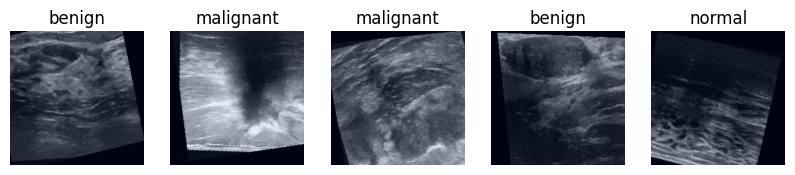

In [12]:
# Function to plot a few images from a batch
def plot_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        image = images[i].permute(1, 2, 0).numpy()
        image = (image * 0.229 + 0.485).clip(0, 1)
        plt.imshow(image)
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Get a batch of images and labels from the DataLoader
images, labels = next(iter(train_loader))

# Display 5 images from the batch
plot_images(images, labels, class_names, num_images=5)

### Transfer Learning

In [13]:
# Load the pre-trained ResNet-18 model
trn_model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 3 output classes (benign, malignant, normal)
num_ftrs = trn_model.fc.in_features
trn_model.fc = nn.Linear(num_ftrs, 3)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trn_model = trn_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.6MB/s]


In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trn_model.parameters(), lr=0.00005, weight_decay=1e-5)

# Early stopping setup
patience = 2  # Stop after 2 epochs without improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Function to evaluate the model on validation sets
def evaluate_model(loader):
    trn_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = trn_model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    loss = running_loss / len(loader.dataset)
    accuracy = 100 * correct / total
    return loss, accuracy

# Training loop with early stopping
num_epochs = 20
for epoch in range(num_epochs):
    trn_model.train()  # Set model to training mode
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        outputs = trn_model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Validation step
    val_loss, val_acc = evaluate_model(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(trn_model.state_dict(), 'best_resnet_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        early_stop = True
        break

Epoch 1/20, Train Loss: 0.8769, Train Accuracy: 58.61%, Val Loss: 0.8265, Val Accuracy: 59.83%
Epoch 2/20, Train Loss: 0.6980, Train Accuracy: 67.22%, Val Loss: 0.6268, Val Accuracy: 72.65%
Epoch 3/20, Train Loss: 0.5902, Train Accuracy: 76.01%, Val Loss: 0.5480, Val Accuracy: 81.20%
Epoch 4/20, Train Loss: 0.5286, Train Accuracy: 77.29%, Val Loss: 0.5095, Val Accuracy: 79.49%
Epoch 5/20, Train Loss: 0.5021, Train Accuracy: 79.49%, Val Loss: 0.4734, Val Accuracy: 84.62%
Epoch 6/20, Train Loss: 0.4472, Train Accuracy: 83.15%, Val Loss: 0.4611, Val Accuracy: 83.76%
Epoch 7/20, Train Loss: 0.3999, Train Accuracy: 84.62%, Val Loss: 0.4436, Val Accuracy: 84.62%
Epoch 8/20, Train Loss: 0.3988, Train Accuracy: 83.52%, Val Loss: 0.4448, Val Accuracy: 83.76%
Epoch 9/20, Train Loss: 0.4117, Train Accuracy: 82.42%, Val Loss: 0.4101, Val Accuracy: 87.18%
Epoch 10/20, Train Loss: 0.3661, Train Accuracy: 86.45%, Val Loss: 0.4171, Val Accuracy: 84.62%
Epoch 11/20, Train Loss: 0.3557, Train Accuracy: 

### Model Evaluation

Accuracy: 0.8120
Precision: [tensor(0.8286), tensor(0.8636), tensor(0.7200)]
Recall: [tensor(0.8788), tensor(0.6129), tensor(0.9000)]


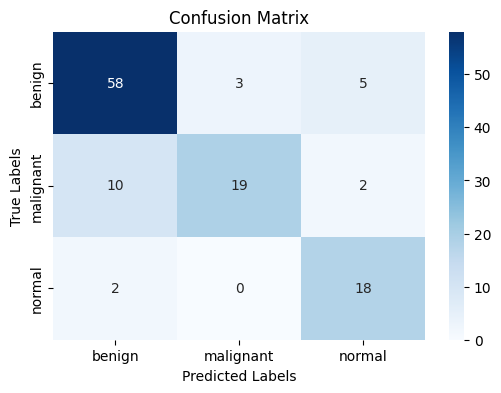

In [15]:
class_names = ['benign', 'malignant', 'normal']

# Initialize accuracy, precision, and recall metrics
acc = Accuracy(task='multiclass', num_classes=len(class_names))
metric_precision = Precision(task='multiclass', num_classes=len(class_names), average=None)
metric_recall = Recall(task='multiclass', num_classes=len(class_names), average=None)

# Collect predictions, true labels, and images list
predictions = []
true_labels = []
images_list = []

trn_model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = trn_model(images)
        _, pred = torch.max(outputs, 1)  # Get predicted class
        acc(pred, labels)
        metric_precision(pred, labels)
        metric_recall(pred, labels)
        predictions.extend(pred.tolist())
        true_labels.extend(labels.tolist())
        images_list.extend(images.cpu())  # Store images

# Compute metrics
accuracy = float(acc.compute())
precision = list(metric_precision.compute())
recall = list(metric_recall.compute())
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

      benign       0.83      0.88      0.85        66
   malignant       0.86      0.61      0.72        31
      normal       0.72      0.90      0.80        20

    accuracy                           0.81       117
   macro avg       0.80      0.80      0.79       117
weighted avg       0.82      0.81      0.81       117



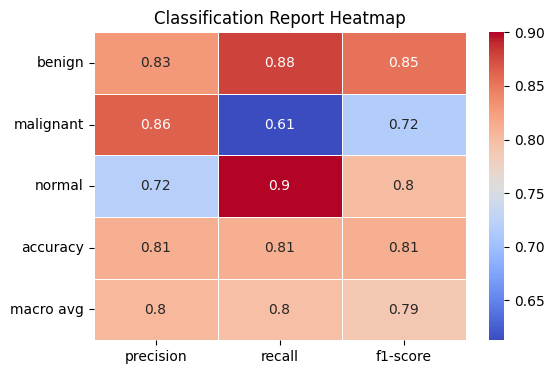

In [16]:
# Generate classification report
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)

# Convert classification report to DataFrame
report_dict = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().iloc[:-1, :3]

# Plot classification report heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(report_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Classification Report Heatmap')
plt.show()

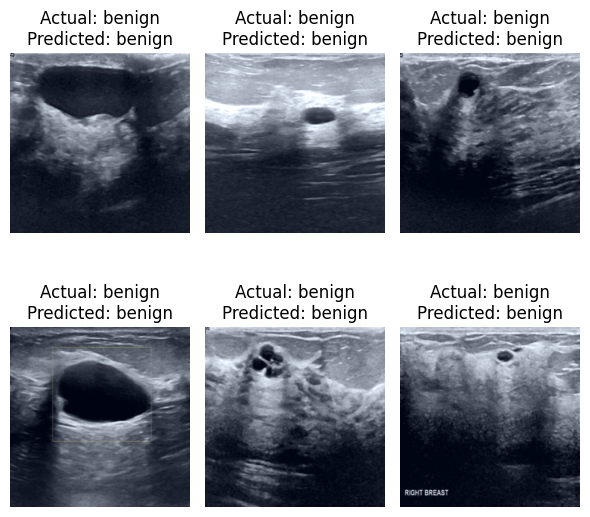

In [17]:
# Function to visualize actual vs predicted results
def plot_actual_vs_predicted(images, actuals, predictions, class_names, num_images=6):
    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        image = images[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C) for plotting
        image = (image * 0.229 + 0.485).clip(0, 1)  # Undo normalization
        plt.imshow(image)
        plt.title(f"Actual: {class_names[actuals[i]]}\nPredicted: {class_names[predictions[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize some images with actual vs predicted labels
plot_actual_vs_predicted(images_list, true_labels, predictions, class_names, num_images=6)